In [16]:
from src.utils import save_predictions_as_imgs, check_accuracy, get_loaders
from PIL import Image
import torch
from src.model import UNET
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
model = UNET()

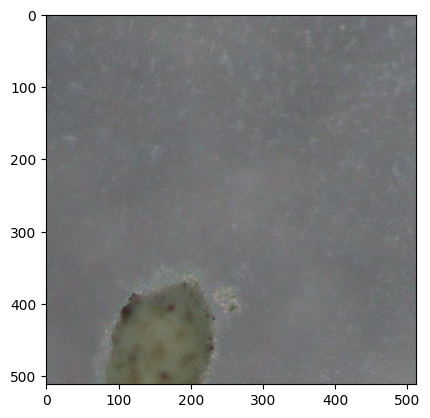

In [20]:
checkpoint = torch.load("my_checkpoint.pth.tar", map_location='cuda')
model.load_state_dict(checkpoint["state_dict"])


img_dir = Path("data/val/imgs")
img_chunks_val = os.listdir(img_dir)

img = Image.open(img_dir / img_chunks_val[0])
img_arr = np.array(img)

plt.imshow(img_arr)

In [24]:
img_tens = torch.from_numpy(img_arr).permute(2, 0, 1).unsqueeze(0).float()

with torch.no_grad():
    logits = model(img_tens)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [28.0..173.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [28.0..173.0].


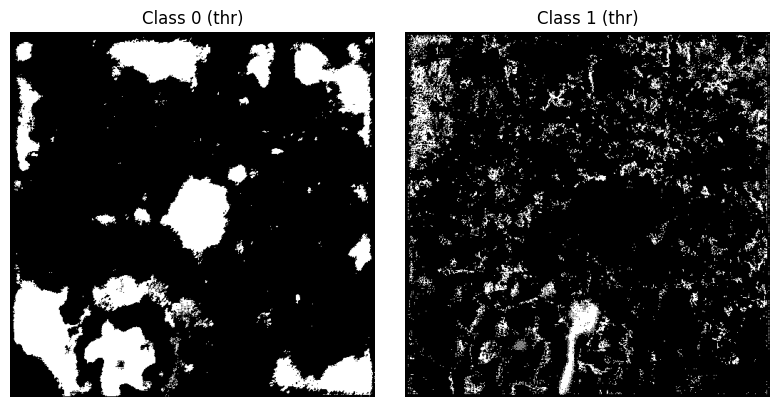

In [32]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def binarize_channels(logits, thresholds=0.5):
    """
    logits: (1, C, H, W)
    thresholds: float or list/1D tensor of length C
    returns:
      probs:  (C, H, W) float32 in [0,1]
      masks:  (C, H, W) bool
    """
    probs = torch.sigmoid(logits).squeeze(0).cpu()            # (C,H,W)
    if np.isscalar(thresholds):
        thr = torch.full((probs.shape[0],), float(thresholds))
    else:
        thr = torch.as_tensor(thresholds, dtype=probs.dtype)
        assert thr.numel() == probs.shape[0], "thresholds must match C"
    thr = thr.view(-1, 1, 1)
    masks = probs > thr
    return probs.numpy(), masks.numpy()

def show_per_channel(img_tens, probs, masks, class_names=None):
    """
    img_tens: (1,3,H,W) tensor in [0,1]
    probs,masks: (C,H,W) numpy
    """
    img_np = img_tens.squeeze(0).permute(1,2,0).cpu().numpy()
    C = probs.shape[0]
    cols = 3
    rows = int(np.ceil(C / cols))
    plt.figure(figsize=(4*cols, 4*rows))
    for i in range(C):
        name = class_names[i] if class_names and i < len(class_names) else f"Class {i}"
        plt.subplot(rows, cols, i+1)
        plt.title(f"{name} (thr)")
        plt.imshow(img_np)
        plt.imshow(masks[i], cmap="gray")  # binary mask overlay
        plt.axis("off")
    plt.tight_layout(); plt.show()

# ---- usage ----
# logits: (1,C,H,W)
probs, masks = binarize_channels(logits, thresholds=0.5)  # or thresholds=[0.3,0.6,...]
show_per_channel(img_tens, probs, masks, class_names=None)


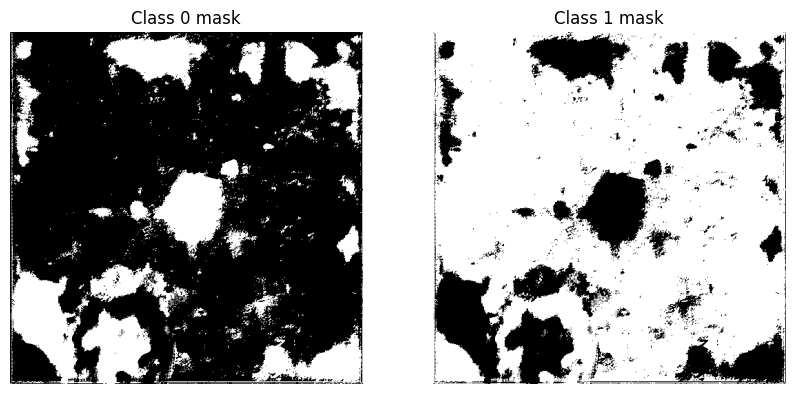

In [29]:
mask = probs.argmax(dim=0)  # (H, W) with class IDs

fig, axes = plt.subplots(1, num_classes, figsize=(5*num_classes, 5))
for i in range(num_classes):
    ax = axes[i] if num_classes > 1 else axes
    ax.imshow(mask == i, cmap="gray")
    ax.set_title(f"Class {i} mask")
    ax.axis("off")
plt.show()
